<center> <h1> Machine Learning for Natural Language Processing <h1> <center>

# Introduction

This notebook is the result of a project by Christos Katsoulakis and Eric Lavergne, carried out as part of the Machine Learning for NLP course at Ensae Paris. We chose to focus on the question answering task, with a model which we learned from scratch and then with a pre-trained model using transformers architectures.

### Imports

We chose to use PyTorch for this project. In particular, we chose to exploit the PyTorch Lightning framework which allows to refactor the code efficiently, and provides tools to quickly improve the training by supporting execution on GPU, optimizing the learning rate, or logging the results.

For the use of pre-trained models such as DistilBERT, we used Hugging Face's fantastic library transformers.

In [ ]:
!pip install datasets
!pip install transformers
!pip install pytorch_lightning

     |████████████████████████████████| 204kB 8.2MB/s 
     |████████████████████████████████| 245kB 32.7MB/s 
     |████████████████████████████████| 112kB 36.0MB/s 
     |████████████████████████████████| 2.1MB 8.1MB/s 
     |████████████████████████████████| 3.3MB 53.9MB/s 
     |████████████████████████████████| 901kB 54.9MB/s 
     |████████████████████████████████| 849kB 7.7MB/s 
     |████████████████████████████████| 276kB 16.8MB/s 
     |████████████████████████████████| 184kB 22.3MB/s 
     |████████████████████████████████| 829kB 25.5MB/s 
     |████████████████████████████████| 1.3MB 15.6MB/s 
     |████████████████████████████████| 143kB 51.8MB/s 
     |████████████████████████████████| 296kB 53.9MB/s 
  Created wheel for PyYAML: filename=PyYAML-5.3.1-cp37-cp37m-linux_x86_64.whl size=44620 sha256=243b38ddedc4e3ecddbe95fae4d45f12fe21d2df55712b4d29d62b158db49b16
  Stored in directory: /root/.cache/pip/wheels/a7/c1/ea/cf5bd31012e735dc1dfea3131a2d5eae7978b251083d6247bd
  Creat

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.nn import functional as F
from torch.utils.data import TensorDataset, DataLoader
from transformers import AutoTokenizer, AutoModel
from datasets import load_dataset
import pytorch_lightning as pl
from keras.preprocessing.sequence import pad_sequences
import nltk
import torchtext

# Data presentation

We chose to work with the question-answering data from SQuAD 1 and SQuAD 2, which are based on extracts from Wikipedia. 

We start by downloading SQuAD 1.

In [ ]:
#Data loading
squad_v1_dataset_train = load_dataset("squad", split="train")
squad_v1_dataset_val = load_dataset("squad", split="validation")

#Data transformation to DataFrame
squad_v1_train_df = pd.DataFrame(squad_v1_dataset_train)
squad_v1_val_df = pd.DataFrame(squad_v1_dataset_val)

Dataset squad downloaded and prepared to /root/.cache/huggingface/datasets/squad/plain_text/1.0.0/4fffa6cf76083860f85fa83486ec3028e7e32c342c218ff2a620fc6b2868483a. Subsequent calls will reuse this data.


Reusing dataset squad (/root/.cache/huggingface/datasets/squad/plain_text/1.0.0/4fffa6cf76083860f85fa83486ec3028e7e32c342c218ff2a620fc6b2868483a)


We can see that the dataset provides a context, a question about this context and an expected answer extracted from the context.

The starting position of an answer is indicated in 'answer_start', the position of the end of the answer is not indicated and will be calculated manually in the data processing part.

In [ ]:
#Training data overview
squad_v1_train_df.head()

,answers,context,id,question,title
0,"{'answer_start': [515], 'text': ['Saint Bernad...","Architecturally, the school has a Catholic cha...",5733be284776f41900661182,To whom did the Virgin Mary allegedly appear i...,University_of_Notre_Dame
1,"{'answer_start': [188], 'text': ['a copper sta...","Architecturally, the school has a Catholic cha...",5733be284776f4190066117f,What is in front of the Notre Dame Main Building?,University_of_Notre_Dame
2,"{'answer_start': [279], 'text': ['the Main Bui...","Architecturally, the school has a Catholic cha...",5733be284776f41900661180,The Basilica of the Sacred heart at Notre Dame...,University_of_Notre_Dame
3,"{'answer_start': [381], 'text': ['a Marian pla...","Architecturally, the school has a Catholic cha...",5733be284776f41900661181,What is the Grotto at Notre Dame?,University_of_Notre_Dame
4,"{'answer_start': [92], 'text': ['a golden stat...","Architecturally, the school has a Catholic cha...",5733be284776f4190066117e,What sits on top of the Main Building at Notre...,University_of_Notre_Dame


The train dataset of SQuAD 1 consists of 87599 context/question/answers triplets.

In [ ]:
#Information on Training data
squad_v1_train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 87599 entries, 0 to 87598
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   answers   87599 non-null  object
 1   context   87599 non-null  object
 2   id        87599 non-null  object
 3   question  87599 non-null  object
 4   title     87599 non-null  object
dtypes: object(5)
memory usage: 3.3+ MB


There is only one ground truth answer given per question.

Mean number of answers : 1.0


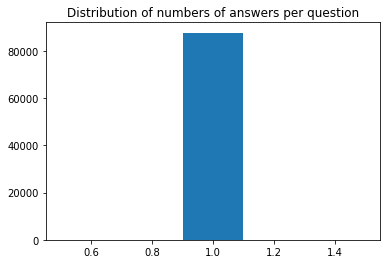

In [ ]:
#Distribution of numbers of answers per question on Training data
nb_answers = []
for i in range(len(squad_v1_train_df)):
    nb_answers.append(len(squad_v1_train_df["answers"][i]["text"]))
print("Mean number of answers : {}".format(np.array(nb_answers).mean()))

plt.hist(nb_answers, bins=5)
plt.title("Distribution of numbers of answers per question")
plt.show()

The validation dataset provides a context, a question about this context and an expected answer extracted from the context. Contrary to train data, there are several possible answers per question. 

In [ ]:
#Validation data overview
squad_v1_val_df.head()

,answers,context,id,question,title
0,"{'answer_start': [177, 177, 177], 'text': ['De...",Super Bowl 50 was an American football game to...,56be4db0acb8001400a502ec,Which NFL team represented the AFC at Super Bo...,Super_Bowl_50
1,"{'answer_start': [249, 249, 249], 'text': ['Ca...",Super Bowl 50 was an American football game to...,56be4db0acb8001400a502ed,Which NFL team represented the NFC at Super Bo...,Super_Bowl_50
2,"{'answer_start': [403, 355, 355], 'text': ['Sa...",Super Bowl 50 was an American football game to...,56be4db0acb8001400a502ee,Where did Super Bowl 50 take place?,Super_Bowl_50
3,"{'answer_start': [177, 177, 177], 'text': ['De...",Super Bowl 50 was an American football game to...,56be4db0acb8001400a502ef,Which NFL team won Super Bowl 50?,Super_Bowl_50
4,"{'answer_start': [488, 488, 521], 'text': ['go...",Super Bowl 50 was an American football game to...,56be4db0acb8001400a502f0,What color was used to emphasize the 50th anni...,Super_Bowl_50


The validation dataset of SQuAD 1 consists of 10570 context/question/answers triplets.

In [ ]:
#Information on Validation data
squad_v1_val_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10570 entries, 0 to 10569
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   answers   10570 non-null  object
 1   context   10570 non-null  object
 2   id        10570 non-null  object
 3   question  10570 non-null  object
 4   title     10570 non-null  object
dtypes: object(5)
memory usage: 413.0+ KB


In validation data, all the questions have at least one answer and the mean number of answers per question is 3.

Mean number of answers : 3.285335856196783
Maximum number of answers : 6


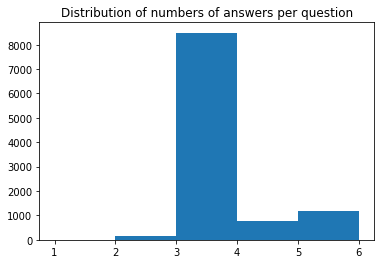

In [ ]:
#Distribution of numbers of answers per question on Validation data
nb_answers = []
for i in range(len(squad_v1_val_df)):
    nb_answers.append(len(squad_v1_val_df["answers"][i]["text"]))
print("Mean number of answers : {}".format(np.array(nb_answers).mean()))
print("Maximum number of answers : {}".format(np.array(nb_answers).max()))

plt.hist(nb_answers, bins=5)
plt.title("Distribution of numbers of answers per question")
plt.show()

The SQuAD dataset deals about various subjects such as Anthropology, Canadian Football and Digestion ; this is a goldmine for building a robust system but also an additional difficulty when learning.

In [ ]:
#List of subjects in training data
list_subject = squad_v1_train_df['title'].unique()
list_subject.sort()
list_subject

array(['2008_Sichuan_earthquake', '2008_Summer_Olympics_torch_relay',
       '51st_state', 'ASCII', 'A_cappella', 'Adolescence',
       'Adult_contemporary_music',
       'Affirmative_action_in_the_United_States', 'Age_of_Enlightenment',
       'Aircraft_carrier', 'Airport', 'Alaska', 'Alexander_Graham_Bell',
       'Alfred_North_Whitehead', 'Alloy', 'Alps', 'Alsace',
       'American_Idol', 'Animal', 'Ann_Arbor,_Michigan', 'Annelid',
       'Antarctica', 'Antenna_(radio)', 'Anthropology',
       'Anti-aircraft_warfare', 'Antibiotics', 'Apollo',
       'Appalachian_Mountains', 'Architecture', 'Arena_Football_League',
       'Armenia', 'Armenians', 'Arnold_Schwarzenegger', 'Arsenal_F.C.',
       'Ashkenazi_Jews', 'Asphalt', 'Aspirated_consonant',
       'Association_football', 'Asthma', 'Athanasius_of_Alexandria',
       'Atlantic_City,_New_Jersey', 'Avicenna', 'BBC_Television',
       'Bacteria', 'Baptists', 'Beer',
       'BeiDou_Navigation_Satellite_System', 'Bermuda', 'Bern', 'Beyon

The subjects in validation data are not the same as in training data.

In [ ]:
#List of subjects in validation data
list_subject = squad_v1_val_df['title'].unique()
list_subject.sort()
list_subject

array(['1973_oil_crisis', 'Amazon_rainforest',
       'American_Broadcasting_Company', 'Apollo_program', 'Black_Death',
       'Chloroplast', 'Civil_disobedience',
       'Computational_complexity_theory', 'Construction', 'Ctenophora',
       'Doctor_Who', 'Economic_inequality', 'European_Union_law', 'Force',
       'French_and_Indian_War', 'Fresno,_California', 'Genghis_Khan',
       'Geology', 'Harvard_University', 'Huguenot', 'Immune_system',
       'Imperialism', 'Intergovernmental_Panel_on_Climate_Change',
       'Islamism', 'Jacksonville,_Florida', 'Kenya', 'Martin_Luther',
       'Newcastle_upon_Tyne', 'Nikola_Tesla', 'Normans', 'Oxygen',
       'Packet_switching', 'Pharmacy', 'Prime_number', 'Private_school',
       'Rhine', 'Scottish_Parliament', 'Sky_(United_Kingdom)',
       'Southern_California', 'Steam_engine', 'Super_Bowl_50', 'Teacher',
       'United_Methodist_Church', 'University_of_Chicago',
       'Victoria_(Australia)', 'Victoria_and_Albert_Museum', 'Warsaw',
      

Now let's look for instance at context, questions and answers related to Antartica.

In [ ]:
#Data related to Antarctica
squad_v1_train_df.loc[squad_v1_train_df['title']=='Antarctica']

,answers,context,id,question,title
30928,"{'answer_start': [160], 'text': ['desert']}","Antarctica, on average, is the coldest, driest...",570c2257ec8fbc190045bc62,What type of land is Antarctica considered to be?,Antarctica
30929,"{'answer_start': [202], 'text': ['200 mm (8 in...","Antarctica, on average, is the coldest, driest...",570c2257ec8fbc190045bc63,What is Antarctica's annual precipitation alon...,Antarctica
30930,"{'answer_start': [392], 'text': ['−63 °C (−81 ...","Antarctica, on average, is the coldest, driest...",570c2257ec8fbc190045bc64,What is Antarctica's average temperature durin...,Antarctica
30931,"{'answer_start': [453], 'text': ['anywhere fro...","Antarctica, on average, is the coldest, driest...",570c2257ec8fbc190045bc65,Approximately how many people live throughout ...,Antarctica
30932,"{'answer_start': [697], 'text': ['mites, nemat...","Antarctica, on average, is the coldest, driest...",570c2257ec8fbc190045bc66,What are some animals native to Antarctica?,Antarctica
...,...,...,...,...,...
31153,"{'answer_start': [120], 'text': ['Geologists']}","Researchers include biologists, geologists, oc...",570e1f340dc6ce1900204dc9,What group of scientists study tectonics?,Antarctica
31154,"{'answer_start': [397], 'text': ['Biologists']}","Researchers include biologists, geologists, oc...",570e1f340dc6ce1900204dcb,Who is interested in the effects of harsh envi...,Antarctica
31155,"{'answer_start': [254], 'text': ['Glaciologist...","Researchers include biologists, geologists, oc...",570e1f340dc6ce1900204dca,Which science is concerned with the study of t...,Antarctica
31156,"{'answer_start': [851], 'text': ['astronomical']}","Researchers include biologists, geologists, oc...",570e1f340dc6ce1900204dcc,What kind of observations use the high elevat...,Antarctica


In [ ]:
#Questions and answers related to a context from Antarctica
print("context: \n", squad_v1_train_df.loc[squad_v1_train_df['title']=='Antarctica', 'context'].iloc[0], "\n")
for i in [0, 2, 3, 5, 8]:
    print("question:", squad_v1_train_df.loc[squad_v1_train_df['title']=='Antarctica', 'question'].iloc[i])
    print("answer:", squad_v1_train_df.loc[squad_v1_train_df['title']=='Antarctica', 'answers'].iloc[i]['text'], "\n")

context: 
 Antarctica, on average, is the coldest, driest, and windiest continent, and has the highest average elevation of all the continents. Antarctica is considered a desert, with annual precipitation of only 200 mm (8 in) along the coast and far less inland. The temperature in Antarctica has reached −89.2 °C (−128.6 °F), though the average for the third quarter (the coldest part of the year) is −63 °C (−81 °F). There are no permanent human residents, but anywhere from 1,000 to 5,000 people reside throughout the year at the research stations scattered across the continent. Organisms native to Antarctica include many types of algae, bacteria, fungi, plants, protista, and certain animals, such as mites, nematodes, penguins, seals and tardigrades. Vegetation, where it occurs, is tundra. 

question: What type of land is Antarctica considered to be?
answer: ['desert'] 

question: What is Antarctica's average temperature during the coldest part of the year?
answer: ['−63 °C (−81 °F)'] 



# Data preprocessing functions

We have to do several operations on raw data to be able to use it efficiently for our training. Firstly, we have to tokenize texts from concatenated question and answer separated by a [SEP] token, using appropriated tokenizer for the model to train. We make all sequences being the same size with padding. Moreover, because the positions of the answers start to extract are expressed in caracters, we have to translate them in terms of tokens used by the model. We also have to determine manually the end of answers.

A function is dedicated to validation data to take into account that several answers are possible.

In [ ]:
def prepare_train_squad_data(squad_df, tokenizer, max_length):
    
    squad_df["answers"] = squad_df["answers"]\
    .apply(lambda x: {**x, **{"answer_stop": [x["answer_start"][0] + len(x["text"][0]) - 1]\
                               if len(x["answer_start"])!=0 else []}})
    
    tokens_ids = []
    masks = []
    start_token_positions = []
    end_token_positions = []

    for ind, (context, question, answer) in enumerate(zip(list(squad_df["context"]), list(squad_df["question"]), list(squad_df["answers"]))):

        tokenized = tokenizer(context, question, padding="max_length", truncation="only_first", max_length=max_length)

        if tokenized == None:
            squad_df = squad_df.drop(ind, axis=0)
        else:
            tokens_ids.append(tokenized["input_ids"])
            masks.append(tokenized["attention_mask"])

            if len(answer["answer_start"]) == 0:
                start_token_positions.append(0)
                end_token_positions.append(0)
            else:
                start = answer["answer_start"][0]
                end = answer["answer_stop"][0]
                tokenized_start = tokenizer(context[:int(start)], max_length=max_length)['input_ids']
                tokenized_end = tokenizer(context[start: end+1], max_length=max_length)['input_ids']
                start_token_position = len(tokenized_start) - 1
                end_token_position = start_token_position + len(tokenized_end) - 3
                start_token_positions.append(start_token_position)
                end_token_positions.append(end_token_position)

    tokens_ids = torch.tensor(np.array(tokens_ids))
    masks = torch.tensor(np.array(masks))
    start_token_positions = torch.tensor(np.array(start_token_positions))
    end_token_positions = torch.tensor(np.array(end_token_positions))

    return tokens_ids, masks, start_token_positions, end_token_positions

In [ ]:
def prepare_val_squad_data(squad_df, tokenizer, max_length):

    squad_df["answers"] = squad_df["answers"]\
    .apply(lambda x: {**x, **{"answer_stop": [x["answer_start"][i] + len(x["text"][i]) - 1\
                              for i in range(len(x["answer_start"]))] if len(x["answer_start"])!=0 else [] }})
    
    tokens_ids = []
    masks = []

    max_nb_answers = 6
    start_end_token_positions = np.ones((len(squad_df), max_nb_answers, 2))*(-1)
    i = 0

    for ind, (context, question, answer) in enumerate(zip(list(squad_df["context"]), list(squad_df["question"]), list(squad_df["answers"]))):

        tokenized = tokenizer(context, question, padding="max_length", truncation="only_first", max_length=max_length)

        if tokenized == None:
            squad_df = squad_df.drop(ind, axis=0)
        else:
            tokens_ids.append(tokenized["input_ids"])
            masks.append(tokenized["attention_mask"])

            if len(answer["answer_start"]) == 0:
                start_end_token_positions[i][0][0] = 0
                start_end_token_positions[i][0][1] = 0
            else :
                for j in range(len(answer["answer_start"])):
                    start = answer["answer_start"][j]
                    end = answer["answer_stop"][j]
                    tokenized_start = tokenizer(context[:int(start)], max_length=max_length)['input_ids']
                    tokenized_end = tokenizer(context[start: end+1], max_length=max_length)['input_ids']
                    start_token_position = len(tokenized_start) - 1
                    end_token_position = start_token_position + len(tokenized_end) - 3
                    start_end_token_positions[i][j][0] = start_token_position
                    start_end_token_positions[i][j][1] = end_token_position

            i += 1

    tokens_ids = torch.tensor(np.array(tokens_ids))
    masks = torch.tensor(np.array(masks))
    start_end_token_positions = torch.tensor(np.array(start_end_token_positions[:i]))

    return tokens_ids, masks, start_end_token_positions

In [ ]:
def prepare_train_squad_data_bert(squad_df):

    squad_df["answers"] = squad_df["answers"]\
    .apply(lambda x: {**x, **{"answer_stop": [x["answer_start"][0] + len(x["text"][0]) - 1]\
                               if len(x["answer_start"])!=0 else []}})
    
    tokens_ids = []
    masks = []

    for context, question in zip(list(squad_df["context"]), list(squad_df["question"])):
        tokenized = tokenizer(context, question, padding="max_length", truncation="only_first", max_length=512)
        tokens_ids.append(tokenized["input_ids"])
        masks.append(tokenized["attention_mask"])

    tokens_ids = torch.tensor(np.array(tokens_ids))
    masks = torch.tensor(np.array(masks))

    start_token_positions = []
    end_token_positions = []
    
    for context, answer in zip(list(squad_df["context"]), list(squad_df["answers"])):
        
        if len(answer["answer_start"]) == 0:
            start_token_positions.append(0)
            end_token_positions.append(0)
        else :
            start = answer["answer_start"][0]
            end = answer["answer_stop"][0]
            start_token_position = len(tokenizer(context[:int(start)])["input_ids"]) - 1
            end_token_position = start_token_position + len(tokenizer(context[start: end+1])["input_ids"]) - 3
            if end_token_position>=512:
                start_token_position = 0
                end_token_position = 0
            start_token_positions.append(start_token_position)
            end_token_positions.append(end_token_position)

    start_token_positions = torch.tensor(np.array(start_token_positions))
    end_token_positions = torch.tensor(np.array(end_token_positions))

    return tokens_ids, masks, start_token_positions, end_token_positions

In [ ]:
def prepare_val_squad_data_bert(squad_df):

    squad_df["answers"] = squad_df["answers"]\
    .apply(lambda x: {**x, **{"answer_stop": [x["answer_start"][i] + len(x["text"][i]) - 1\
                              for i in range(len(x["answer_start"]))] if len(x["answer_start"])!=0 else [] }})
    
    tokens_ids = []
    masks = []

    for context, question in zip(list(squad_df["context"]), list(squad_df["question"])):
        tokenized = tokenizer(context, question, padding="max_length", truncation="only_first", max_length=512)
        tokens_ids.append(tokenized["input_ids"])
        masks.append(tokenized["attention_mask"])

    tokens_ids = torch.tensor(np.array(tokens_ids))
    masks = torch.tensor(np.array(masks))
    
    max_nb_answers = 6
    start_end_token_positions = np.ones((len(squad_df),max_nb_answers, 2))*(-1)

    for i, (context, answer) in enumerate(zip(list(squad_df["context"]), list(squad_df["answers"]))):
      
        if len(answer["answer_start"]) == 0:
            start_end_token_positions[i][0][0] = 0
            start_end_token_positions[i][0][1] = 0
        else :
            for j in range(len(answer["answer_start"])):
                start = answer["answer_start"][j]
                end = answer["answer_stop"][j]
                start_token_position = len(tokenizer(context[:int(start)])["input_ids"]) - 1
                end_token_position = start_token_position + len(tokenizer(context[start: end+1])["input_ids"]) - 3
                if end_token_position>=512:
                    start_token_position = 0
                    end_token_position = 0
                start_end_token_positions[i][j][0] = start_token_position
                start_end_token_positions[i][j][1] = end_token_position

    start_end_token_positions = torch.tensor(np.array(start_end_token_positions))

    return tokens_ids, masks, start_end_token_positions

# Metrics

To quantitatively evaluate the performance of a question-answering model, two metrics predominate: Exact Matching and F1 Score. 

The Exact Matching is simply the proportion of anwers extracted by the model that correspond exactly to the expected answer.

The F1 Score is the harmonic mean between precision (the number of shared words between the expected answer and the prediction, divided by the total number of words in the prediction) and recall (the number of shared words, divided by the total number of words in the expected answer).

In [ ]:
def exact_matching(start_and_end_predicted, start_end_true):
    start_predicted = start_and_end_predicted[:,0]
    end_predicted = start_and_end_predicted[:,1]
    batch_size = len(start_predicted)
    tot_matching = 0
    for i in range(batch_size):
        max_matching = 0
        for start_true, end_true in start_end_true[i]:
            local_matching = (start_true == start_predicted[i])*(end_true == end_predicted[i])*1.0
            if local_matching > max_matching:
                max_matching = local_matching
        tot_matching += max_matching
    tot_matching /= batch_size
    return tot_matching

def qa_f1_score(start_and_end_predicted, start_end_true):
    batch_size = len(start_and_end_predicted)
    mean_qa_f1_s = 0
    for i in range(batch_size):
        start_predicted, end_predicted = start_and_end_predicted[i]
        predicted_span = end_predicted + 1 - start_predicted
        max_qa_f1_s = 0
        for start_true, end_true in start_end_true[i]:
            true_span = end_true + 1 - start_true
            nb_shared_words = max(0, min(end_true, end_predicted) + 1 - max(start_true, start_predicted))
            recall = (nb_shared_words / predicted_span) if predicted_span>0 else 0
            precision = (nb_shared_words / true_span)
            qa_f1_s = 2*recall*precision/(recall+precision) if (recall+precision) != 0 else 0

            if qa_f1_s > max_qa_f1_s:
                max_qa_f1_s = qa_f1_s
        
        mean_qa_f1_s += max_qa_f1_s
    mean_qa_f1_s /= batch_size
    return mean_qa_f1_s

# Transformer-based from scratch

One of the two main options we chose is to train from scratch a light transformer to perform extractive question answering.

## Downloading Glove embeddings

Actually, we did not train everything from scratch as we chose to use Glove embeddings vectors pretrained on Wikipedia as the input of the transformer.

In [ ]:
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip glove*.zip

--2021-04-24 16:25:08--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2021-04-24 16:25:08--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2021-04-24 16:25:08--  http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glove.6

We particularly used Glove embeddings of size 100.

In [ ]:
embeddings_index = {}
file = open('glove.6B.100d.txt', encoding='utf-8')
for line in file:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
file.close()

We create the dictionary of the ids related to Glove vocabulary to be able to tokenize word sequences then ; we add a token for padding, one for the [CLS] token at the beginning of each sequence, one for the [SEP] token separating context and question and ending the sequence and finally one for all unknown tokens not in Glove vocabulary.

In [ ]:
word_to_ids = dict(zip(embeddings_index.keys(), range(1, len(embeddings_index)+1)))
word_to_ids["[pad]"] = 0
word_to_ids["[CLS]"] = len(word_to_ids)
word_to_ids["[SEP]"] = len(word_to_ids)
word_to_ids["[Unk]"] = len(word_to_ids)

In [ ]:
glove_vectors = list(embeddings_index.values())

In [ ]:
#create random embeddings for cls and sep
glove_vectors.append(np.random.randn(len(glove_vectors[0])))
glove_vectors.append(np.random.randn(len(glove_vectors[0])))
#create embeddings for unknown with mean embeddings
glove_vectors.append(np.array(glove_vectors).mean(axis=0))
glove_vectors.insert(0, np.zeros(len(glove_vectors[0])))

Glove vocabulary is of size 400000.

In [ ]:
len(glove_vectors)

400004

In [ ]:
len(word_to_ids)

400004

We also create a reverse dictionary in order to be able to decode a sequence of ids.

In [ ]:
ids_to_word = {v:k for k,v in word_to_ids.items()}

## Architecture definition

As transformer deals with data in parallel, we need to add positional embeddings to standard word embeddings in order to provide the information of the position of each element of the sequence to the model. We chose to use sinusoidal positional embeddings.

In [ ]:
class PositionalEncoder(pl.LightningModule):
    def __init__(self, seq_length, d_model):
        super().__init__()
        self.seq_length = seq_length
        self.d_model = d_model

    def forward(self, x):
        positions = np.arange(self.seq_length)[:, np.newaxis]
        indices = np.arange(self.d_model)[np.newaxis, :]
        angles = positions / (
            1e4 ** (
                2*indices/self.d_model
            )
        )
        encodings = np.zeros(shape=angles.shape)
        encodings[:, 0::2] = np.sin(angles[:, 0::2])
        encodings[:, 1::2] = np.cos(angles[:, 1::2])

        pos_encodings = torch.tensor(encodings).type_as(x)

        return torch.add(x, pos_encodings)

The architecture consists of a relatively light transformer with 4 layers and 4 heads, and a labeling head with two feedforward.

In [ ]:
class QA_transformer(pl.LightningModule):
    def __init__(self, learning_rate, vector_size=100, train_embeddings=False):
        super().__init__()
        weights = torch.FloatTensor(glove_vectors)
        self.vector_size = vector_size
        if train_embeddings:
            self.embeddings = nn.Embedding.from_pretrained(weights, freeze=False)
        else:
            self.embeddings = nn.Embedding.from_pretrained(weights, freeze=True)
        self.pos_encoder = PositionalEncoder(seq_length=max_length, d_model=self.vector_size)
        encoder_layers = nn.TransformerEncoderLayer(d_model=self.vector_size, nhead=4, dim_feedforward=256)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layers, 4, norm=nn.LayerNorm(normalized_shape=self.vector_size, eps=1e-6))
        self.labeling_head = nn.Linear(self.vector_size, 2)
        self.learning_rate = learning_rate

    def forward(self, input_ids, attention_mask):
        embds = self.embeddings(input_ids)
        embds = self.pos_encoder(embds)
        embds = embds.permute(1,0,2)
        model_outputs = self.transformer_encoder(src=embds, src_key_padding_mask=attention_mask)
        model_outputs = model_outputs.permute(1,0,2)
        start_and_end_outputs = self.labeling_head(model_outputs)

        return start_and_end_outputs

    def predict_from_outputs(self, outputs):
        #return start and and predicted positions
        #from outputs of shape batch_size, sequence_length_size, 2 (number of labels per words)
        predictions = torch.argmax(outputs, dim=1)
        return predictions

    def configure_optimizers(self):

        optimizer = torch.optim.Adam(self.parameters(), lr=self.learning_rate)
        return optimizer

    def training_step(self, train_batch, batch_idx):

        context_and_question_tokens, masks, start_positions, end_positions = train_batch

        start_and_end_outputs = self.forward(input_ids=context_and_question_tokens, attention_mask=masks)

        start_cross_entropy = nn.CrossEntropyLoss()(start_and_end_outputs[:,:,0], start_positions)
        end_cross_entropy = nn.CrossEntropyLoss()(start_and_end_outputs[:,:,1], end_positions)
        loss = (start_cross_entropy + end_cross_entropy)/2
        self.log('train_loss', loss)

        return loss

    def validation_step(self, val_batch, batch_idx):
        context_and_question_tokens, masks, start_end_positions = val_batch
        start_and_end_outputs = self.forward(input_ids=context_and_question_tokens, attention_mask=masks)
        start_and_end_predictions = self.predict_from_outputs(start_and_end_outputs)

        f1_s = qa_f1_score(start_and_end_predictions, start_end_positions)
        matching = exact_matching(start_and_end_predictions, start_end_positions)

        self.log('val_f1_score', f1_s, prog_bar=True)
        self.log('val_exact_matching', matching, prog_bar=True)

    def test_step(self, batch, batch_idx):
        context_and_question_tokens, masks, start_and_end_positions = batch
        start_and_end_outputs = self.forward(input_ids=context_and_question_tokens, attention_mask=masks)
        start_and_end_predictions = self.predict_from_outputs(start_and_end_outputs)

        f1_s = qa_f1_score(start_and_end_predictions, start_and_end_positions)
        matching = exact_matching(start_and_end_predictions, start_and_end_positions)

        self.log('test_f1_score', f1_s)
        self.log('test_exact_matching', matching)

## Creating custom tokenizer

To be able to tokenize according to Glove vocabulary, we need to define a tokenizer ourselves. We relied on the word_tokenizer of nltk.

In [ ]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

We add the [CLS] token before each sequence and the [SEP] token between the two sequences and after.

In [ ]:
def custom_tokenizer(seq1, seq2=""):
    if len(seq2)!=0:
        return ["[CLS]"] + nltk.word_tokenize(seq1.lower()) + ["[SEP]"] + nltk.word_tokenize(seq2.lower()) + ["[SEP]"]
    else:
        return ["[CLS]"] + nltk.word_tokenize(seq1.lower()) + ["[SEP]"]

We then define the function to translate word sequences to tokens ids. Particularly, it pads data to a specified length, and computes mask to not consider extra padding tokens.

In [ ]:
def text_encode(seq1, seq2="", padding="non", truncation="only_first", max_length=126):
    tokens = custom_tokenizer(seq1, seq2)

    if truncation == "only_first":
        if len(tokens)>max_length-1:
            return None

    tokens_ids = [word_to_ids.get(token, word_to_ids["[Unk]"]) for token in tokens]
    len_tokens_ids = len(tokens_ids)
    masks = list(np.zeros(len_tokens_ids))
    if padding == "max_length":
        if max_length > len_tokens_ids:
            masks += list(np.ones(max_length - len_tokens_ids))
            tokens_ids += list(np.zeros(max_length - len_tokens_ids))

    return {"input_ids": tokens_ids, "attention_mask": masks}

We define functions to decode the ids sequences computed previously.

In [ ]:
def torch_decode(tokens_ids):
    return [ids_to_word[token_id.item()] for token_id in tokens_ids]

def decode(tokens_ids):
    return [ids_to_word[token_id] for token_id in tokens_ids]

Let's test our encoder / decoder functions.

In [ ]:
decode(text_encode("I am a cat.", "And you ?", max_length=12)["input_ids"])

['[CLS]', 'i', 'am', 'a', 'cat', '.', '[SEP]', 'and', 'you', '?', '[SEP]']

In [ ]:
decode(text_encode("I am a cat.", max_length=12)["input_ids"])

['[CLS]', 'i', 'am', 'a', 'cat', '.', '[SEP]']

## Tokenizing and preprocessing data

To chose the size of the sequences given to the model, let's look at the size of the tokenized sequences before padding.

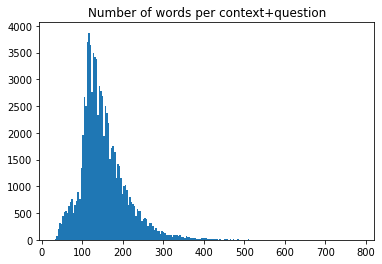

In [ ]:
nb_words = []
for context, question in zip(list(squad_v1_train_df["context"]), list(squad_v1_train_df["question"])):
  nb_words.append(len(custom_tokenizer(context, question)))

plt.hist(nb_words, bins=200)
plt.title("Number of words per context+question")
plt.show()

We chose a length of 300 to have a reasonable size without cutting too much data.

In [ ]:
max_length = 300

Let's preprocess and tokenize squad 1 data.

In [ ]:
train_tokens_ids, train_masks, train_start_positions, train_end_positions = prepare_train_squad_data(squad_v1_train_df, text_encode, max_length)

In [ ]:
val_tokens_ids, val_masks, val_start_end_positions = prepare_val_squad_data(squad_v1_val_df, text_encode, max_length)

Let's check if data has been well preprocessed.

In [ ]:
for ind, start, end in zip(range(4), list(train_start_positions), list(train_end_positions)):
    print("context: \n", squad_v1_train_df.iloc[ind]['context'])
    print("question:", squad_v1_train_df.iloc[ind]['question'])
    if len(squad_v1_train_df.iloc[ind]['answers']['text'])==0:
        print("answer:", squad_v1_train_df.iloc[ind]['answers']['text'])
    else:
        print("answer:", squad_v1_train_df.iloc[ind]['answers']['text'][0])
    print("predicted answer:", torch_decode(train_tokens_ids[ind][start:end+1]), "\n")

context: 
 Architecturally, the school has a Catholic character. Atop the Main Building's gold dome is a golden statue of the Virgin Mary. Immediately in front of the Main Building and facing it, is a copper statue of Christ with arms upraised with the legend "Venite Ad Me Omnes". Next to the Main Building is the Basilica of the Sacred Heart. Immediately behind the basilica is the Grotto, a Marian place of prayer and reflection. It is a replica of the grotto at Lourdes, France where the Virgin Mary reputedly appeared to Saint Bernadette Soubirous in 1858. At the end of the main drive (and in a direct line that connects through 3 statues and the Gold Dome), is a simple, modern stone statue of Mary.
question: To whom did the Virgin Mary allegedly appear in 1858 in Lourdes France?
answer: Saint Bernadette Soubirous
predicted answer: ['saint', 'bernadette', 'soubirous'] 

context: 
 Architecturally, the school has a Catholic character. Atop the Main Building's gold dome is a golden statue 

In [ ]:
for ind, start_end in zip(range(4), list(val_start_end_positions)):
    print("context: \n", squad_v1_val_df.iloc[ind]['context'])
    print("question:", squad_v1_val_df.iloc[ind]['question'])
    if len(squad_v1_val_df.iloc[ind]['answers']['text'])==0:
        print("answer:", squad_v1_val_df.iloc[ind]['answers']['text'])
    else:
        print("answer:", squad_v1_val_df.iloc[ind]['answers']['text'][0])
    start = int((start_end[0][0]).item())
    end = int((start_end[0][1]).item())
    print("predicted answer:", torch_decode(val_tokens_ids[ind][start:end+1]), "\n")

context: 
 Super Bowl 50 was an American football game to determine the champion of the National Football League (NFL) for the 2015 season. The American Football Conference (AFC) champion Denver Broncos defeated the National Football Conference (NFC) champion Carolina Panthers 24–10 to earn their third Super Bowl title. The game was played on February 7, 2016, at Levi's Stadium in the San Francisco Bay Area at Santa Clara, California. As this was the 50th Super Bowl, the league emphasized the "golden anniversary" with various gold-themed initiatives, as well as temporarily suspending the tradition of naming each Super Bowl game with Roman numerals (under which the game would have been known as "Super Bowl L"), so that the logo could prominently feature the Arabic numerals 50.
question: Which NFL team represented the AFC at Super Bowl 50?
answer: Denver Broncos
predicted answer: ['denver', 'broncos'] 

context: 
 Super Bowl 50 was an American football game to determine the champion of t

In [ ]:
train_tokens_ids = train_tokens_ids.type(torch.LongTensor)
train_masks = train_masks.type(torch.BoolTensor)
val_tokens_ids = val_tokens_ids.type(torch.LongTensor)
val_masks = val_masks.type(torch.BoolTensor)

In [ ]:
#data selection
size_train = len(train_tokens_ids)
size_valid = 5000

train_dataset = TensorDataset(train_tokens_ids[:size_train], train_masks[:size_train], train_start_positions[:size_train], train_end_positions[:size_train])
val_dataset = TensorDataset(val_tokens_ids[:size_valid], val_masks[:size_valid], val_start_end_positions[:size_valid])
train_loader = DataLoader(train_dataset, batch_size=16)
val_loader = DataLoader(val_dataset, batch_size=16)

## Training

We initialize an instance of the model.

In [ ]:
model = QA_transformer(learning_rate = 10**(-3), train_embeddings=False)

We compute the training on Colab's GPU to accelerate it.

In [ ]:
trainer = pl.Trainer(gpus=1, max_epochs=5)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores


We can finally train the model.

In [ ]:
trainer.fit(model, train_loader, val_loader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                | Type               | Params
-----------------------------------------------------------
0 | embeddings          | Embedding          | 40.0 M
1 | pos_encoder         | PositionalEncoder  | 0     
2 | transformer_encoder | TransformerEncoder | 369 K 
3 | labeling_head       | Linear             | 202   
-----------------------------------------------------------
369 K     Trainable params
40.0 M    Non-trainable params
40.4 M    Total params
161.481   Total estimated model params size (MB)


1

## Evaluating the results

We can compute metrics on datasets.

In [ ]:
#quantitative results
result_val = trainer.test(test_dataloaders=val_loader)
print(result_val)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_exact_matching': 0.1096000000834465,
 'test_f1_score': 0.15935756266117096}
--------------------------------------------------------------------------------
[{'test_f1_score': 0.15935756266117096, 'test_exact_matching': 0.1096000000834465}]


And we can also evaluate visually the performances of the model.

In [ ]:
#qualitative results on training data
index = [0, 100, 200, 250, 500, 1000, 2000, 2500, 3000]
start_end_prediction = np.argmax(model(train_tokens_ids[index].cuda(), train_masks[index].cuda()).detach().cpu(), axis=1) 
print(start_end_prediction)
for ind, start_end in zip(index, list(start_end_prediction)):
    print("context: \n", squad_v1_train_df.iloc[ind]['context'])
    print("question:", squad_v1_train_df.iloc[ind]['question'])
    if len(squad_v1_train_df.iloc[ind]['answers']['text'])==0:
        print("answer:", squad_v1_train_df.iloc[ind]['answers']['text'])
    else:
        print("answer:", squad_v1_train_df.iloc[ind]['answers']['text'][0])
    print("predicted answer:", torch_decode(train_tokens_ids[ind][start_end[0]:start_end[1]+1]), "\n")

tensor([[ 93,  93],
        [  9,  59],
        [  5,   5],
        [ 33,  33],
        [ 17,  17],
        [ 32,  32],
        [  1,  30],
        [ 23,  23],
        [129,   4]])
context: 
 Architecturally, the school has a Catholic character. Atop the Main Building's gold dome is a golden statue of the Virgin Mary. Immediately in front of the Main Building and facing it, is a copper statue of Christ with arms upraised with the legend "Venite Ad Me Omnes". Next to the Main Building is the Basilica of the Sacred Heart. Immediately behind the basilica is the Grotto, a Marian place of prayer and reflection. It is a replica of the grotto at Lourdes, France where the Virgin Mary reputedly appeared to Saint Bernadette Soubirous in 1858. At the end of the main drive (and in a direct line that connects through 3 statues and the Gold Dome), is a simple, modern stone statue of Mary.
question: To whom did the Virgin Mary allegedly appear in 1858 in Lourdes France?
answer: Saint Bernadette Soubi

In [ ]:
#qualitative results on validation data
index = [0, 100, 200, 250, 500, 1000, 2000, 2500, 3000]
start_end_prediction = np.argmax(model(val_tokens_ids[index].cuda(), val_masks[index].cuda()).detach().cpu(), axis=1) #trainer.predict(model, DataLoader(TensorDataset(val_tokens_ids[index], val_masks[index]), batch_size=8))[0], axis=1)
print(start_end_prediction)
for ind, start_end in zip(index, list(start_end_prediction)):
    print("context: \n", squad_v1_val_df.iloc[ind]['context'])
    print("question:", squad_v1_val_df.iloc[ind]['question'])
    if len(squad_v1_val_df.iloc[ind]['answers']['text'])==0:
        print("answer:", squad_v1_val_df.iloc[ind]['answers']['text'])
    else:
        print("answer:", squad_v1_val_df.iloc[ind]['answers']['text'][0])
    print("predicted answer:", torch_decode(val_tokens_ids[ind][start_end[0]:start_end[1]+1]), "\n")

tensor([[ 67,  67],
        [ 46,  46],
        [ 14,   7],
        [  8,  54],
        [  4,   4],
        [ 48,  48],
        [  9,   9],
        [  4, 126],
        [ 14,  14]])
context: 
 Super Bowl 50 was an American football game to determine the champion of the National Football League (NFL) for the 2015 season. The American Football Conference (AFC) champion Denver Broncos defeated the National Football Conference (NFC) champion Carolina Panthers 24–10 to earn their third Super Bowl title. The game was played on February 7, 2016, at Levi's Stadium in the San Francisco Bay Area at Santa Clara, California. As this was the 50th Super Bowl, the league emphasized the "golden anniversary" with various gold-themed initiatives, as well as temporarily suspending the tradition of naming each Super Bowl game with Roman numerals (under which the game would have been known as "Super Bowl L"), so that the logo could prominently feature the Arabic numerals 50.
question: Which NFL team represe

# Bert Fine-tuning

One of the two main options we chose is to fine-tune a pre-trained language model transformer of type BERT. It is important to note that this is a pre-trained model for language modelling and not question answering.

Fine-tuning makes it possible to exploit the representations already learned by a model. This is very useful when little training data or computational resources are available, especially when one considers the enormous cost of learning most recent language models. This allows for a decent performance with little task-specific training data, where training from scratch would require much more data to achieve the same results. Many pre-trained models are available through the Hugging Face library, which we have exploited here.

## Architecture definition

We replace the language modeling head of the BERT-based model by a labeling head computing extractive question-answering. It is composed of a feedforward network with two outputs applied to each representation extracted by BERT which give the probabilities of the first and last token of the answer to be extracted. The losses used to train the model are the Cross Entropy related to the prediction of the first and last token of the answer. The validation step computes the F1 score and Exact Matching. Moreover, we used a layerwise learning rate to avoid catastrophic forgeting in the first layers.

In [ ]:
class QA_finetuned_BERT(pl.LightningModule):
    def __init__(self, model_link, learning_rate=10**(-3), layerwise_gamma=1.):
        super().__init__()
        self.tokenizer = AutoTokenizer.from_pretrained(model_link)
        self.language_model = AutoModel.from_pretrained(model_link)
        self.l_model_size = 768 
        self.labeling_head = nn.Linear(self.l_model_size, 2)
        self.learning_rate = learning_rate
        self.layerwise_gamma = layerwise_gamma

    def forward(self, input_ids, attention_mask):
        model_outputs = self.language_model(input_ids=input_ids, attention_mask=attention_mask)[0]
        start_and_end_outputs = self.labeling_head(model_outputs)
        return start_and_end_outputs

    def predict_from_outputs(self, outputs):
        #return start and and predicted positions
        #from outputs of shape batch_size, sequence_length_size, 2 (number of labels per words)
        predictions = torch.argmax(outputs, dim=1)
        return predictions

    def configure_optimizers(self):
        
        params_to_fit = []

        layerwise_lr = self.learning_rate

        params_to_fit.append({"params": self.labeling_head.parameters(), "lr": layerwise_lr})

        #for transformer with 6 layers (Distilbert)
        for i in range(5,-1,-1):
            layerwise_lr *= self.layerwise_gamma
            params_to_fit.append({
                "params" : self.language_model.transformer.layer[i].parameters(),
                "lr" : layerwise_lr})

        optimizer = torch.optim.Adam(params_to_fit, lr=self.learning_rate)

        return optimizer

    def training_step(self, train_batch, batch_idx):

        context_and_question_tokens, masks, start_positions, end_positions = train_batch
        start_and_end_outputs = self.forward(input_ids=context_and_question_tokens, attention_mask=masks)

        start_cross_entropy = nn.CrossEntropyLoss()(start_and_end_outputs[:,:,0], start_positions)
        end_cross_entropy = nn.CrossEntropyLoss()(start_and_end_outputs[:,:,1], end_positions)
        loss = (start_cross_entropy + end_cross_entropy)/2
        self.log('train_loss', loss)

        return loss

    def validation_step(self, val_batch, batch_idx):
        context_and_question_tokens, masks, start_end_positions = val_batch
        start_and_end_outputs = self.forward(input_ids=context_and_question_tokens, attention_mask=masks)
        start_and_end_predictions = self.predict_from_outputs(start_and_end_outputs)

        f1_s = qa_f1_score(start_and_end_predictions, start_end_positions)
        matching = exact_matching(start_and_end_predictions, start_end_positions)

        self.log('val_f1_score', f1_s)
        self.log('val_exact_matching', matching, prog_bar=True)

    def test_step(self, batch, batch_idx):
        context_and_question_tokens, masks, start_and_end_positions = batch
        start_and_end_outputs = self.forward(input_ids=context_and_question_tokens, attention_mask=masks)
        start_and_end_predictions = self.predict_from_outputs(start_and_end_outputs)

        f1_s = qa_f1_score(start_and_end_predictions, start_and_end_positions)
        matching = exact_matching(start_and_end_predictions, start_and_end_positions)

        self.log('test_f1_score', f1_s)
        self.log('test_exact_matching', matching)

## Tokenizing and preprocessing data

We used the tokenizer related to the DistilBERT model.

In [ ]:
#Model pretrained selection
model_link = "distilbert-base-cased" # "bert-base-cased"
tokenizer = AutoTokenizer.from_pretrained(model_link)

In [ ]:
#Prepare training data
train_tokens_ids, train_masks, train_start_positions, train_end_positions = prepare_train_squad_data_bert(squad_v1_train_df)

Token indices sequence length is longer than the specified maximum sequence length for this model (525 > 512). Running this sequence through the model will result in indexing errors


In [ ]:
#Prepare validation data
val_tokens_ids, val_masks, val_start_end_positions = prepare_val_squad_data_bert(squad_v1_val_df)

We can verify that the computing of the tokens and the answer tokens positions have been successful.

In [ ]:
#Verification
for ind, start, end in zip(range(5), list(train_start_positions), list(train_end_positions)):
    print("context: \n", squad_v1_train_df.iloc[ind]['context'])
    print("question:", squad_v1_train_df.iloc[ind]['question'])
    if len(squad_v1_train_df.iloc[ind]['answers']['text'])==0:
        print("answer:", squad_v1_train_df.iloc[ind]['answers']['text'])
    else:
        print("answer:", squad_v1_train_df.iloc[ind]['answers']['text'][0])
    print("predicted answer:", tokenizer.decode(train_tokens_ids[ind][start:end+1]), "\n")

context: 
 Architecturally, the school has a Catholic character. Atop the Main Building's gold dome is a golden statue of the Virgin Mary. Immediately in front of the Main Building and facing it, is a copper statue of Christ with arms upraised with the legend "Venite Ad Me Omnes". Next to the Main Building is the Basilica of the Sacred Heart. Immediately behind the basilica is the Grotto, a Marian place of prayer and reflection. It is a replica of the grotto at Lourdes, France where the Virgin Mary reputedly appeared to Saint Bernadette Soubirous in 1858. At the end of the main drive (and in a direct line that connects through 3 statues and the Gold Dome), is a simple, modern stone statue of Mary.
question: To whom did the Virgin Mary allegedly appear in 1858 in Lourdes France?
answer: Saint Bernadette Soubirous
predicted answer: Saint Bernadette Soubirous 

context: 
 Architecturally, the school has a Catholic character. Atop the Main Building's gold dome is a golden statue of the Vir

Finally, we choose the number of data used for training and validation.

In [ ]:
#data selection
size_train = len(train_tokens_ids)
size_valid = 5000

#data loader
train_dataset = TensorDataset(train_tokens_ids[:size_train], train_masks[:size_train], train_start_positions[:size_train], train_end_positions[:size_train])
val_dataset = TensorDataset(val_tokens_ids[:size_valid], val_masks[:size_valid], val_start_end_positions[:size_valid])
train_loader = DataLoader(train_dataset, batch_size=16)
val_loader = DataLoader(val_dataset, batch_size=16)

## Training

We initialize an instance of the model.

In [ ]:
#model
model = QA_finetuned_BERT(model_link=model_link, learning_rate=10**(-3), layerwise_gamma=0.6) 

We compute the training on Colab's GPU to accelerate it.

In [ ]:
#trainer
trainer = pl.Trainer(gpus=1, max_epochs=2, auto_lr_find=True)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores


We can firstly used the learning rate finder prodided by the Lightning framework in order to find quickly a good learning rate (the one used before the loss went up).

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/utilities/distributed.py:68: UserWarning: you defined a validation_step but have no val_dataloader. Skipping validation loop
  warnings.warn(*args, **kwargs)
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type            | Params
---------------------------------------------------
0 | language_model | DistilBertModel | 65.2 M
1 | labeling_head  | Linear          | 1.5 K 
---------------------------------------------------
65.2 M    Trainable params
0         Non-trainable params
65.2 M    Total params
260.770   Total estimated model params size (MB)


Restored states from the checkpoint file at /content/lr_find_temp_model.ckpt


0.0001445439770745928


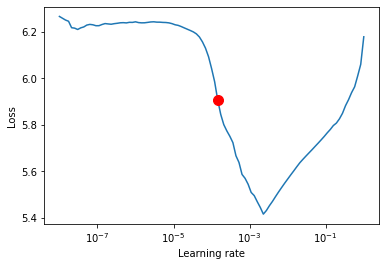

In [ ]:
#tune learning rate
lr_finder = trainer.tuner.lr_find(model, train_dataloader=train_loader)
fig = lr_finder.plot(suggest=True)
fig.show()
model.learning_rate = lr_finder.suggestion()
print(model.learning_rate)

We can finally train the model.

In [ ]:
#training 
trainer.fit(model, train_loader, val_loader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type            | Params
---------------------------------------------------
0 | language_model | DistilBertModel | 65.2 M
1 | labeling_head  | Linear          | 1.5 K 
---------------------------------------------------
65.2 M    Trainable params
0         Non-trainable params
65.2 M    Total params
260.770   Total estimated model params size (MB)


1

## Evaluating the results

We can use the framework tensorboard to explore the logs made during the training.

In [ ]:
#%load_ext tensorboard

In [ ]:
#%tensorboard --logdir lightning_logs/ 

In [ ]:
#loaded_model = QA_finetuned_BERT.load_from_checkpoint("lightning_logs/")

We can compute metrics on datasets.

In [ ]:
#quantitative results
result_val = trainer.test(test_dataloaders=val_loader)
print(result_val)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_exact_matching': 0.6690633893013, 'test_f1_score': 0.7736994624137878}
--------------------------------------------------------------------------------
[{'test_f1_score': 0.7736994624137878, 'test_exact_matching': 0.6690633893013}]


And we can also evaluate visually the performances of the model.

In [ ]:
#qualitative results on training data
index = [0, 100, 200, 250, 500, 1000, 2000, 2500, 3000]
start_end_prediction = np.argmax(model(train_tokens_ids[index].cuda(), train_masks[index].cuda()).detach().cpu(), axis=1) #np.argmax(trainer.predict(model, DataLoader(train_tokens_ids[index], batch_size=8))[0], axis=1)
print(start_end_prediction)
for ind, start_end in zip(index, list(start_end_prediction)):
    print("context: \n", squad_v2_train_df.iloc[ind]['context'])
    print("question:", squad_v2_train_df.iloc[ind]['question'])
    if len(squad_v2_train_df.iloc[ind]['answers']['text'])==0:
        print("answer:", squad_v2_train_df.iloc[ind]['answers']['text'])
    else:
        print("answer:", squad_v2_train_df.iloc[ind]['answers']['text'][0])
    print("predicted answer:", tokenizer.decode(train_tokens_ids[ind][start_end[0]:start_end[1]+1]), "\n")

tensor([[120, 126],
        [ 77,  77],
        [  2,   2],
        [  8,  11],
        [ 75,  78],
        [ 31,  34],
        [ 26,  29],
        [ 53,  54],
        [150, 150]])
context: 
 Architecturally, the school has a Catholic character. Atop the Main Building's gold dome is a golden statue of the Virgin Mary. Immediately in front of the Main Building and facing it, is a copper statue of Christ with arms upraised with the legend "Venite Ad Me Omnes". Next to the Main Building is the Basilica of the Sacred Heart. Immediately behind the basilica is the Grotto, a Marian place of prayer and reflection. It is a replica of the grotto at Lourdes, France where the Virgin Mary reputedly appeared to Saint Bernadette Soubirous in 1858. At the end of the main drive (and in a direct line that connects through 3 statues and the Gold Dome), is a simple, modern stone statue of Mary.
question: To whom did the Virgin Mary allegedly appear in 1858 in Lourdes France?
answer: Saint Bernadette Soubi

In [ ]:
#qualitative results on validation data
index = [0, 100, 200, 250, 500, 1000, 2000, 2500, 3000]
start_end_prediction = np.argmax(model(val_tokens_ids[index].cuda(), val_masks[index].cuda()).detach().cpu(), axis=1) #trainer.predict(model, DataLoader(TensorDataset(val_tokens_ids[index], val_masks[index]), batch_size=8))[0], axis=1)
print(start_end_prediction)
for ind, start_end in zip(index, list(start_end_prediction)):
    print("context: \n", squad_v2_val_df.iloc[ind]['context'])
    print("question:", squad_v2_val_df.iloc[ind]['question'])
    if len(squad_v2_val_df.iloc[ind]['answers']['text'])==0:
        print("answer:", squad_v2_val_df.iloc[ind]['answers']['text'])
    else:
        print("answer:", squad_v2_val_df.iloc[ind]['answers']['text'][0])
    print("predicted answer:", tokenizer.decode(val_tokens_ids[ind][start_end[0]:start_end[1]+1]), "\n")

tensor([[ 34,  35],
        [ 51,  54],
        [ 30,  31],
        [ 54,  57],
        [ 32,  35],
        [ 37,  39],
        [ 75,  68],
        [ 60,  60],
        [111, 114]])
context: 
 Super Bowl 50 was an American football game to determine the champion of the National Football League (NFL) for the 2015 season. The American Football Conference (AFC) champion Denver Broncos defeated the National Football Conference (NFC) champion Carolina Panthers 24–10 to earn their third Super Bowl title. The game was played on February 7, 2016, at Levi's Stadium in the San Francisco Bay Area at Santa Clara, California. As this was the 50th Super Bowl, the league emphasized the "golden anniversary" with various gold-themed initiatives, as well as temporarily suspending the tradition of naming each Super Bowl game with Roman numerals (under which the game would have been known as "Super Bowl L"), so that the logo could prominently feature the Arabic numerals 50.
question: Which NFL team represe

# Bert Fine-tuning on SQuAD 2

Let's deal with a problem of higher difficulty by considering SQuAD 2 which has pairs of context-question that admits no answer. To take into account this new constraint, we indicate the first token of a sequence as a special token that must be pointed out by the model when the context does not contain an answer to a question. Since around 30\% of the training data are unanswerable question, we weight the loss differently to penalize more errors on answerable questions than errors on unanswerable questions.

## Architecture definition

In [ ]:
class QA_finetuned_BERT_v2(pl.LightningModule):
    
    def __init__(self, model_link, weight, learning_rate=10**(-3), layerwise_gamma=1.):
        super().__init__()
        self.tokenizer = AutoTokenizer.from_pretrained(model_link)
        self.language_model = AutoModel.from_pretrained(model_link)
        self.l_model_size = 768 
        self.labeling_head = nn.Linear(self.l_model_size, 2)
        self.learning_rate = learning_rate
        self.layerwise_gamma = layerwise_gamma
        self.weight = weight

    def forward(self, input_ids, attention_mask):
        model_outputs = self.language_model(input_ids=input_ids, attention_mask=attention_mask)[0]
        start_and_end_outputs = self.labeling_head(model_outputs)
        return start_and_end_outputs

    def predict_from_outputs(self, outputs):
        predictions = torch.argmax(outputs, dim=1)
        return predictions

    def configure_optimizers(self):
        
        params_to_fit = []

        layerwise_lr = self.learning_rate

        params_to_fit.append({"params": self.labeling_head.parameters(), "lr": layerwise_lr})

        #for transformer with 6 layers (Distilbert)
        for i in range(5,-1,-1):
            layerwise_lr *= self.layerwise_gamma
            params_to_fit.append({
                "params" : self.language_model.transformer.layer[i].parameters(),
                "lr" : layerwise_lr})

        optimizer = torch.optim.Adam(params_to_fit, lr=self.learning_rate)

        return optimizer

    def training_step(self, train_batch, batch_idx):

        context_and_question_tokens, masks, start_positions, end_positions = train_batch
        start_and_end_outputs = self.forward(input_ids=context_and_question_tokens, attention_mask=masks)

        start_cross_entropy = nn.CrossEntropyLoss(weight=self.weight)(start_and_end_outputs[:,:,0], start_positions)
        end_cross_entropy = nn.CrossEntropyLoss(weight=self.weight)(start_and_end_outputs[:,:,1], end_positions)
        loss = (start_cross_entropy + end_cross_entropy)/2
        self.log('train_loss', loss)

        return loss

    def validation_step(self, val_batch, batch_idx):
        context_and_question_tokens, masks, start_end_positions = val_batch
        start_and_end_outputs = self.forward(input_ids=context_and_question_tokens, attention_mask=masks)
        start_and_end_predictions = self.predict_from_outputs(start_and_end_outputs)

        f1_s = qa_f1_score(start_and_end_predictions, start_end_positions)
        matching = exact_matching(start_and_end_predictions, start_end_positions)

        self.log('val_f1_score', f1_s)
        self.log('val_exact_matching', matching, prog_bar=True)

    def test_step(self, batch, batch_idx):
        context_and_question_tokens, masks, start_and_end_positions = batch
        start_and_end_outputs = self.forward(input_ids=context_and_question_tokens, attention_mask=masks)
        start_and_end_predictions = self.predict_from_outputs(start_and_end_outputs)

        f1_s = qa_f1_score(start_and_end_predictions, start_and_end_positions)
        matching = exact_matching(start_and_end_predictions, start_and_end_positions)

        self.log('test_f1_score', f1_s)
        self.log('test_exact_matching', matching)

## Data import and presentation

In [ ]:
#Data loading
squad_v2_dataset_train = load_dataset("squad_v2", split="train")
squad_v2_dataset_val = load_dataset("squad_v2", split="validation")

#Data transformation to DataFrame
squad_v2_train_df = pd.DataFrame(squad_v2_dataset_train)
squad_v2_val_df = pd.DataFrame(squad_v2_dataset_val)

Dataset squad_v2 downloaded and prepared to /root/.cache/huggingface/datasets/squad_v2/squad_v2/2.0.0/ba48bc29b974701e9ba8d80ac94f3e3df924aba41b764dcf9851debea7c672e4. Subsequent calls will reuse this data.


Reusing dataset squad_v2 (/root/.cache/huggingface/datasets/squad_v2/squad_v2/2.0.0/ba48bc29b974701e9ba8d80ac94f3e3df924aba41b764dcf9851debea7c672e4)


We can see that the dataset provides a context, a question about this context and an expected answer extracted from the context.

In [ ]:
#Training data overview
squad_v2_train_df.head()

,answers,context,id,question,title
0,"{'answer_start': [269], 'text': ['in the late ...",Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ b...,56be85543aeaaa14008c9063,When did Beyonce start becoming popular?,Beyoncé
1,"{'answer_start': [207], 'text': ['singing and ...",Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ b...,56be85543aeaaa14008c9065,What areas did Beyonce compete in when she was...,Beyoncé
2,"{'answer_start': [526], 'text': ['2003']}",Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ b...,56be85543aeaaa14008c9066,When did Beyonce leave Destiny's Child and bec...,Beyoncé
3,"{'answer_start': [166], 'text': ['Houston, Tex...",Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ b...,56bf6b0f3aeaaa14008c9601,In what city and state did Beyonce grow up?,Beyoncé
4,"{'answer_start': [276], 'text': ['late 1990s']}",Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ b...,56bf6b0f3aeaaa14008c9602,In which decade did Beyonce become famous?,Beyoncé


The train dataset of SQUAD 2 consists of 130319 context/question/answers triplets.

In [ ]:
#Information on Training data
squad_v2_train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 130319 entries, 0 to 130318
Data columns (total 5 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   answers   130319 non-null  object
 1   context   130319 non-null  object
 2   id        130319 non-null  object
 3   question  130319 non-null  object
 4   title     130319 non-null  object
dtypes: object(5)
memory usage: 5.0+ MB


There can be one ground truth answer (66.6%) or no answer (33.4%) per question.

Mean number of answers : 0.6662190471074824


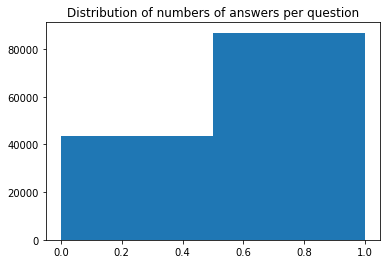

In [ ]:
#Distribution of numbers of answers per question on Training data
nb_answers = []
for i in range(len(squad_v2_train_df)):
    nb_answers.append(len(squad_v2_train_df["answers"][i]["text"]))
print("Mean number of answers : {}".format(np.array(nb_answers).mean()))

plt.hist(nb_answers, bins=2)
plt.title("Distribution of numbers of answers per question")
plt.show()

For the validation dataset, contrary to train data, sometimes there are several possible answers per question.

In [ ]:
#Validation data overview
squad_v2_val_df.head()

,answers,context,id,question,title
0,"{'answer_start': [159, 159, 159, 159], 'text':...",The Normans (Norman: Nourmands; French: Norman...,56ddde6b9a695914005b9628,In what country is Normandy located?,Normans
1,"{'answer_start': [94, 87, 94, 94], 'text': ['1...",The Normans (Norman: Nourmands; French: Norman...,56ddde6b9a695914005b9629,When were the Normans in Normandy?,Normans
2,"{'answer_start': [256, 256, 256, 256], 'text':...",The Normans (Norman: Nourmands; French: Norman...,56ddde6b9a695914005b962a,From which countries did the Norse originate?,Normans
3,"{'answer_start': [308, 308, 308, 308], 'text':...",The Normans (Norman: Nourmands; French: Norman...,56ddde6b9a695914005b962b,Who was the Norse leader?,Normans
4,"{'answer_start': [671, 649, 671, 671], 'text':...",The Normans (Norman: Nourmands; French: Norman...,56ddde6b9a695914005b962c,What century did the Normans first gain their ...,Normans


The validation dataset of SQUAD 2 consists of 11873 context/question/answers triplets.

In [ ]:
#Information on Validation data
squad_v2_val_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11873 entries, 0 to 11872
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   answers   11873 non-null  object
 1   context   11873 non-null  object
 2   id        11873 non-null  object
 3   question  11873 non-null  object
 4   title     11873 non-null  object
dtypes: object(5)
memory usage: 463.9+ KB


Mean number of answers : 1.7099300934894297
Maximum number of answers : 6


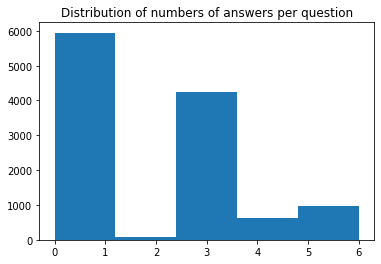

In [ ]:
#Distribution of numbers of answers per question on Validation data
nb_answers = []
for i in range(len(squad_v2_val_df)):
    nb_answers.append(len(squad_v2_val_df["answers"][i]["text"]))
print("Mean number of answers : {}".format(np.array(nb_answers).mean()))
print("Maximum number of answers : {}".format(np.array(nb_answers).max()))

plt.hist(nb_answers, bins=5)
plt.title("Distribution of numbers of answers per question")
plt.show()

The SQuAD dataset deals about various subjects such as Anthropology, Canadian Football and Digestion ; this is a goldmine for building a robust system but also an additional difficulty when learning.

In [ ]:
#List of subjects in training data
list_subject = squad_v2_train_df['title'].unique()
list_subject.sort()
list_subject

array(['2008_Sichuan_earthquake', '2008_Summer_Olympics_torch_relay',
       '51st_state', 'ASCII', 'A_cappella', 'Adolescence',
       'Adult_contemporary_music',
       'Affirmative_action_in_the_United_States', 'Age_of_Enlightenment',
       'Aircraft_carrier', 'Airport', 'Alaska', 'Alexander_Graham_Bell',
       'Alfred_North_Whitehead', 'Alloy', 'Alps', 'Alsace',
       'American_Idol', 'Animal', 'Ann_Arbor,_Michigan', 'Annelid',
       'Antarctica', 'Antenna_(radio)', 'Anthropology',
       'Anti-aircraft_warfare', 'Antibiotics', 'Apollo',
       'Appalachian_Mountains', 'Architecture', 'Arena_Football_League',
       'Armenia', 'Armenians', 'Arnold_Schwarzenegger', 'Arsenal_F.C.',
       'Ashkenazi_Jews', 'Asphalt', 'Aspirated_consonant',
       'Association_football', 'Asthma', 'Athanasius_of_Alexandria',
       'Atlantic_City,_New_Jersey', 'Avicenna', 'BBC_Television',
       'Bacteria', 'Baptists', 'Beer',
       'BeiDou_Navigation_Satellite_System', 'Bermuda', 'Bern', 'Beyon

The subjects in validation data are not the same as in training data.

In [ ]:
#List of subjects in validation data
list_subject = squad_v2_val_df['title'].unique()
list_subject.sort()
list_subject

array(['1973_oil_crisis', 'Amazon_rainforest', 'Black_Death',
       'Civil_disobedience', 'Computational_complexity_theory',
       'Construction', 'Ctenophora', 'Economic_inequality',
       'European_Union_law', 'Force', 'French_and_Indian_War',
       'Fresno,_California', 'Geology', 'Harvard_University', 'Huguenot',
       'Immune_system', 'Imperialism',
       'Intergovernmental_Panel_on_Climate_Change', 'Islamism',
       'Jacksonville,_Florida', 'Normans', 'Oxygen', 'Packet_switching',
       'Pharmacy', 'Prime_number', 'Private_school', 'Rhine',
       'Scottish_Parliament', 'Sky_(United_Kingdom)',
       'Southern_California', 'Steam_engine', 'University_of_Chicago',
       'Victoria_(Australia)', 'Warsaw', 'Yuan_dynasty'], dtype=object)

Let's look for instance at context, questions and answers related to Antartica.

In [ ]:
#Data related to Antarctica
squad_v2_train_df.loc[squad_v2_train_df['title']=='Antarctica']

,answers,context,id,question,title
42333,"{'answer_start': [0], 'text': ['Antarctica']}","Antarctica, on average, is the coldest, driest...",570d9260b3d812140066da51,Which continent is the highest in elevation?,Antarctica
42334,"{'answer_start': [202], 'text': ['200 mm']}","Antarctica, on average, is the coldest, driest...",570d9260b3d812140066da52,What is the annual precipitation rate of coast...,Antarctica
42335,"{'answer_start': [392], 'text': ['−63 °C']}","Antarctica, on average, is the coldest, driest...",570d9260b3d812140066da53,What is the average coldest temperature?,Antarctica
42336,"{'answer_start': [295], 'text': ['−89.2 °C']}","Antarctica, on average, is the coldest, driest...",570d9260b3d812140066da54,What is the coldest recorded temperature?,Antarctica
42337,"{'answer_start': [780], 'text': ['tundra']}","Antarctica, on average, is the coldest, driest...",570d9260b3d812140066da55,Ehat is the vegetation type on Antarctica?,Antarctica
...,...,...,...,...,...
42853,"{'answer_start': [1347], 'text': ['Amundsen–Sc...","Researchers include biologists, geologists, oc...",570e1f340dc6ce1900204dcd,Where is the largest neutrino telescope on Earth?,Antarctica
42854,"{'answer_start': [], 'text': []}","Researchers include biologists, geologists, oc...",5ad2d28ed7d075001a42a388,What do astrophysicists at the Scott-Aumundsen...,Antarctica
42855,"{'answer_start': [], 'text': []}","Researchers include biologists, geologists, oc...",5ad2d28ed7d075001a42a389,What was built 2 mi below the Amundsen-Scott s...,Antarctica
42856,"{'answer_start': [], 'text': []}","Researchers include biologists, geologists, oc...",5ad2d28ed7d075001a42a38a,Why are astronomical observations better made ...,Antarctica


In [ ]:
#Questions and answers related to a context from Antarctica
print("context: \n", squad_v2_train_df.loc[squad_v2_train_df['title']=='Antarctica', 'context'].iloc[0], "\n")
for i in [0, 2, 3, 5, 8]:
    print("question:", squad_v2_train_df.loc[squad_v2_train_df['title']=='Antarctica', 'question'].iloc[i])
    print("answer:", squad_v2_train_df.loc[squad_v2_train_df['title']=='Antarctica', 'answers'].iloc[i]['text'], "\n")

context: 
 Antarctica, on average, is the coldest, driest, and windiest continent, and has the highest average elevation of all the continents. Antarctica is considered a desert, with annual precipitation of only 200 mm (8 in) along the coast and far less inland. The temperature in Antarctica has reached −89.2 °C (−128.6 °F), though the average for the third quarter (the coldest part of the year) is −63 °C (−81 °F). There are no permanent human residents, but anywhere from 1,000 to 5,000 people reside throughout the year at the research stations scattered across the continent. Organisms native to Antarctica include many types of algae, bacteria, fungi, plants, protista, and certain animals, such as mites, nematodes, penguins, seals and tardigrades. Vegetation, where it occurs, is tundra. 

question: Which continent is the highest in elevation?
answer: ['Antarctica'] 

question: What is the average coldest temperature?
answer: ['−63 °C'] 

question: What is the coldest recorded temperat

Some questions have no answer for the given context as illustrated above.

## Tokenizing and preprocessing data

We used the tokenizer related to the DistilBERT model.

In [ ]:
#Model pretrained selection
model_link = "distilbert-base-cased" # "bert-base-cased"
tokenizer = AutoTokenizer.from_pretrained(model_link)

In [ ]:
#Prepare train data
train_tokens_ids, train_masks, train_start_positions, train_end_positions = prepare_train_squad_data_bert(squad_v2_train_df)

Token indices sequence length is longer than the specified maximum sequence length for this model (525 > 512). Running this sequence through the model will result in indexing errors


In [ ]:
#Prepare validation data
val_tokens_ids, val_masks, val_start_end_positions = prepare_val_squad_data_bert(squad_v2_val_df)

We can verify that the computing of the tokens and the answer tokens positions have been successful.

In [ ]:
#Verification
for ind, start, end in zip(range(4), list(train_start_positions), list(train_end_positions)):
    print("context: \n", squad_v2_train_df.iloc[ind]['context'])
    print("question:", squad_v2_train_df.iloc[ind]['question'])
    if len(squad_v2_train_df.iloc[ind]['answers']['text'])==0:
        print("answer:", squad_v2_train_df.iloc[ind]['answers']['text'])
    else:
        print("answer:", squad_v2_train_df.iloc[ind]['answers']['text'][0])
    print("predicted answer:", tokenizer.decode(train_tokens_ids[ind][start:end+1]), "\n")

context: 
 Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ bee-YON-say) (born September 4, 1981) is an American singer, songwriter, record producer and actress. Born and raised in Houston, Texas, she performed in various singing and dancing competitions as a child, and rose to fame in the late 1990s as lead singer of R&B girl-group Destiny's Child. Managed by her father, Mathew Knowles, the group became one of the world's best-selling girl groups of all time. Their hiatus saw the release of Beyoncé's debut album, Dangerously in Love (2003), which established her as a solo artist worldwide, earned five Grammy Awards and featured the Billboard Hot 100 number-one singles "Crazy in Love" and "Baby Boy".
question: When did Beyonce start becoming popular?
answer: in the late 1990s
predicted answer: in the late 1990s 

context: 
 Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ bee-YON-say) (born September 4, 1981) is an American singer, songwriter, record producer and actress. Born and raised in Ho

Finally, we choose the number of data used for training and validation.

In [ ]:
#data selection
size_train = 100000
size_valid = 10000

#data loader
train_dataset = TensorDataset(train_tokens_ids[:size_train], train_masks[:size_train], train_start_positions[:size_train], train_end_positions[:size_train])
val_dataset = TensorDataset(val_tokens_ids[:size_valid], val_masks[:size_valid], val_start_end_positions[:size_valid])
train_loader = DataLoader(train_dataset, batch_size=16)
val_loader = DataLoader(val_dataset, batch_size=16)

In [ ]:
#weight error selection
weight = torch.ones(512) * 1.0 
weight[0] = 0.09
weight = weight.cuda()

## Training

We initialize an instance of the model.

In [ ]:
#model
model = QA_finetuned_BERT_v2(model_link=model_link, weight=weight, learning_rate=10**(-3), layerwise_gamma=0.6)

We compute the training on Colab's GPU to accelerate it.

In [ ]:
#trainer
trainer = pl.Trainer(gpus=1, max_epochs=2, auto_lr_find=True)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores


We can firstly use the learning rate finder prodided by the Lightning framework in order to find quickly a good learning rate (the one used before the loss went up).

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/utilities/distributed.py:68: UserWarning: you defined a validation_step but have no val_dataloader. Skipping validation loop
  warnings.warn(*args, **kwargs)
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type            | Params
---------------------------------------------------
0 | language_model | DistilBertModel | 65.2 M
1 | labeling_head  | Linear          | 1.5 K 
---------------------------------------------------
65.2 M    Trainable params
0         Non-trainable params
65.2 M    Total params
260.770   Total estimated model params size (MB)


Restored states from the checkpoint file at /content/lr_find_temp_model.ckpt


0.0001445439770745928


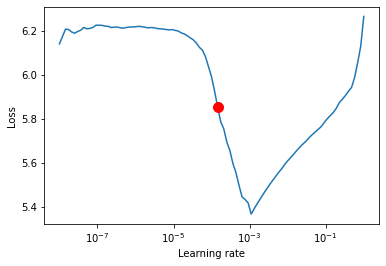

In [ ]:
#tune learning rate
lr_finder = trainer.tuner.lr_find(model, train_dataloader=train_loader)
fig = lr_finder.plot(suggest=True)
fig.show()
model.learning_rate = lr_finder.suggestion()
print(model.learning_rate)

We can finally train the model.

In [ ]:
#training
trainer.fit(model, train_loader, val_loader) 

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type            | Params
---------------------------------------------------
0 | language_model | DistilBertModel | 65.2 M
1 | labeling_head  | Linear          | 1.5 K 
---------------------------------------------------
65.2 M    Trainable params
0         Non-trainable params
65.2 M    Total params
260.770   Total estimated model params size (MB)


1

## Evaluating the results

We can use the framework tensorboard to explore the logs made during the training.

In [ ]:
#%load_ext tensorboard

In [ ]:
#%tensorboard --logdir lightning_logs/ 

In [ ]:
#loaded_model = QA_finetuned_BERT.load_from_checkpoint("lightning_logs/")

We can compute metrics on datasets.

In [ ]:
#quantitative results
result_val = trainer.test(test_dataloaders=val_loader)
print(result_val)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_exact_matching': 0.39010000228881836,
 'test_f1_score': 0.44341278076171875}
--------------------------------------------------------------------------------
[{'test_f1_score': 0.44341278076171875, 'test_exact_matching': 0.39010000228881836}]


And we can also evaluate visually the performances of the model.

In [ ]:
#qualitative results on training data
index = [0, 100, 200, 250, 500, 1000, 2000, 2500, 3000]
start_end_prediction = np.argmax(model(train_tokens_ids[index].cuda(), train_masks[index].cuda()).detach().cpu(), axis=1) #np.argmax(trainer.predict(model, DataLoader(train_tokens_ids[index], batch_size=8))[0], axis=1)
print(start_end_prediction)
for ind, start_end in zip(index, list(start_end_prediction)):
    print("context: \n", squad_v2_train_df.iloc[ind]['context'])
    print("question:", squad_v2_train_df.iloc[ind]['question'])
    if len(squad_v2_train_df.iloc[ind]['answers']['text'])==0:
        print("answer:", squad_v2_train_df.iloc[ind]['answers']['text'])
    else:
        print("answer:", squad_v2_train_df.iloc[ind]['answers']['text'][0])
    print("predicted answer:", tokenizer.decode(train_tokens_ids[ind][start_end[0]:start_end[1]+1]), "\n")

tensor([[ 63,  64],
        [ 47,  47],
        [ 11,  11],
        [171, 178],
        [ 15,  26],
        [  2,   2],
        [ 88,  91],
        [ 69,  94],
        [125, 129]])
context: 
 Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ bee-YON-say) (born September 4, 1981) is an American singer, songwriter, record producer and actress. Born and raised in Houston, Texas, she performed in various singing and dancing competitions as a child, and rose to fame in the late 1990s as lead singer of R&B girl-group Destiny's Child. Managed by her father, Mathew Knowles, the group became one of the world's best-selling girl groups of all time. Their hiatus saw the release of Beyoncé's debut album, Dangerously in Love (2003), which established her as a solo artist worldwide, earned five Grammy Awards and featured the Billboard Hot 100 number-one singles "Crazy in Love" and "Baby Boy".
question: When did Beyonce start becoming popular?
answer: in the late 1990s
predicted answer: late 1990s 

conte

In [ ]:
#qualitative results on validation data
index = [0, 100, 200, 250, 500, 1000, 2000, 2500, 3000]
start_end_prediction = np.argmax(model(val_tokens_ids[index].cuda(), val_masks[index].cuda()).detach().cpu(), axis=1) #trainer.predict(model, DataLoader(TensorDataset(val_tokens_ids[index], val_masks[index]), batch_size=8))[0], axis=1)
print(start_end_prediction)
for ind, start_end in zip(index, list(start_end_prediction)):
    print("context: \n", squad_v2_val_df.iloc[ind]['context'])
    print("question:", squad_v2_val_df.iloc[ind]['question'])
    if len(squad_v2_val_df.iloc[ind]['answers']['text'])==0:
        print("answer:", squad_v2_val_df.iloc[ind]['answers']['text'])
    else:
        print("answer:", squad_v2_val_df.iloc[ind]['answers']['text'][0])
    print("predicted answer:", tokenizer.decode(val_tokens_ids[ind][start_end[0]:start_end[1]+1]), "\n")

tensor([[ 41,  41],
        [ 18,  20],
        [ 53,  62],
        [  0,   0],
        [ 95,  96],
        [ 47,  48],
        [ 13,  15],
        [ 46,  48],
        [297, 298]])
context: 
 The Normans (Norman: Nourmands; French: Normands; Latin: Normanni) were the people who in the 10th and 11th centuries gave their name to Normandy, a region in France. They were descended from Norse ("Norman" comes from "Norseman") raiders and pirates from Denmark, Iceland and Norway who, under their leader Rollo, agreed to swear fealty to King Charles III of West Francia. Through generations of assimilation and mixing with the native Frankish and Roman-Gaulish populations, their descendants would gradually merge with the Carolingian-based cultures of West Francia. The distinct cultural and ethnic identity of the Normans emerged initially in the first half of the 10th century, and it continued to evolve over the succeeding centuries.
question: In what country is Normandy located?
answer: France
pre